In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys
sys.path.append('..')
import functools
import math

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq_torch

In [26]:
mixmeans_test = torch.tensor([[  1.8033],
                           [ -1.4296],
                           [ -1.9691],
                           [  1.2147],
                           [ -6.9166],
                           [-11.5672],
                           [ -1.5860],
                           [ -4.3302],
                           [  8.7410],
                           [ -1.3793],
                           [ -4.8774],
                           [  2.3949]])
mixvars_test = torch.ones((12,1))
mixweights_test = torch.ones(12)/12

In [27]:
def logprob_mixgaussians(x):
    return bvbq_torch.distributions.MixtureDiagonalNormalDistribution.logprob_(
                        x,mixmeans_test,mixvars_test,mixweights_test).reshape(-1,1)
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

xdata = torch.linspace(-20,20,51).reshape(-1,1)
ydata = logprob_mixgaussians(xdata)
logprobgp = bvbq_torch.gp.SimpleGP(1,kind='smatern32',noise=0,zeromax=True)
logprobgp.mean = -10.0
logprobgp.fix_mean()
logprobgp.fix_noise()
logprobgp.set_data(xdata,ydata,empirical_params=False)
# logprobgp.optimize_params(tol=1e-1)

In [28]:
ydata.shape

torch.Size([51, 1])

In [29]:
gp = bvbq_torch.gp.SimpleGP(1,kind='smatern32',noise=1e-2)
gp.set_data(xdata,ydata)
gp.mean = -10.0
gp.fix_mean()
gp.fix_noise()
gp.optimize_params(tol=1e-1)

tensor(1., grad_fn=<LogBackward>) tensor(1., grad_fn=<LogBackward>)
tensor(1.6341, grad_fn=<LogBackward>) tensor(1.3310, grad_fn=<LogBackward>)
tensor(2.1585, grad_fn=<LogBackward>) tensor(1.5363, grad_fn=<LogBackward>)
tensor(2.9973, grad_fn=<LogBackward>) tensor(1.7991, grad_fn=<LogBackward>)
tensor(3.9925, grad_fn=<LogBackward>) tensor(2.0419, grad_fn=<LogBackward>)
tensor(5.3154, grad_fn=<LogBackward>) tensor(2.2802, grad_fn=<LogBackward>)
tensor(7.0132, grad_fn=<LogBackward>) tensor(2.5033, grad_fn=<LogBackward>)
tensor(9.2323, grad_fn=<LogBackward>) tensor(2.7578, grad_fn=<LogBackward>)
tensor(12.1525, grad_fn=<LogBackward>) tensor(3.0216, grad_fn=<LogBackward>)
tensor(15.9247, grad_fn=<LogBackward>) tensor(3.6163, grad_fn=<LogBackward>)
tensor(22.6235, grad_fn=<LogBackward>) tensor(2.2306, grad_fn=<LogBackward>)


{'raw_theta': tensor(22.6235), 'raw_lengthscale': tensor(2.1170)}

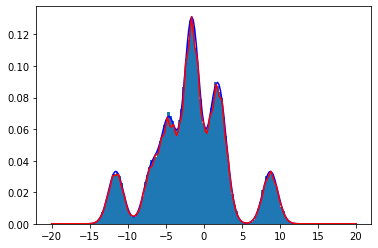

In [30]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot).detach().numpy()
# yplot1 = logprob_t(xplot,2.5)
yplot2 = logprobgp.predict(xplot,return_cov=False).detach().numpy()
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
samples1 = bvbq_torch.distributions.MixtureDiagonalNormalDistribution.sample_(100000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test).detach().numpy()
plt.hist(samples1.flatten(),density=True,bins=100);

In [36]:
bvbq_torch.distributions.DiagonalNormalDistribution.sample_

<function bvbq_torch.distributions.DiagonalNormalDistribution.sample_(n, mean, var)>

In [37]:
nmixtures = 3
ndim = 1
mixmeans = torch.randn(nmixtures,1)
mixvars = torch.distributions.HalfNormal(1.0).sample((nmixtures,1))
mixweights = torch.distributions.Dirichlet(torch.ones(nmixtures)).sample()
mean = torch.randn((1,))
var = torch.distributions.HalfNormal(1.0).sample((1,))

In [71]:
alpha_relbo = 1e-1
maxiter_relbo = 300
alpha_boost = 1e-1
maxiter_boost = 100
maxiter = 20

mixmeans = torch.zeros(1,ndim)
mixvars = (20.0/3)**2*torch.ones(1,ndim)
mixweights = torch.ones(1)
for k in range(maxiter):
    mean,var = bvbq_torch.bvbq.propose_component_mvn_mixmvn_relbo(
                logprobgp,mixmeans,mixvars,mixweights)
    mixmeans,mixvars,mixweights = bvbq_torch.bvbq.update_distribution_mvn_mixmvn(
                                            logprobgp,
                                            mean,var,
                                            mixmeans,mixvars,
                                            mixweights,
                                            lr=1e-1/(k+1),
                                            decaying_lr=False)

    print(mixmeans[-1],mixvars[-1],mixweights[-1])
distrib = bvbq_torch.distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,mixweights)

tensor([-2.2078]) tensor([6.6722]) tensor(0.9304)
tensor([-12.0710]) tensor([0.5296]) tensor(0.0771)
tensor([-8.6986]) tensor([4.8301]) tensor(0.0472)
tensor([2.5669]) tensor([0.7356]) tensor(0.1158)
tensor([0.3903]) tensor([3.7438]) tensor(0.0685)
tensor([-1.1703]) tensor([4.5613]) tensor(0.0069)
tensor([-0.1537]) tensor([5.9365]) tensor(0.0013)
tensor([-1.1049]) tensor([4.7973]) tensor(0.0037)
tensor([-6.6341]) tensor([2.5489]) tensor(0.0389)
tensor([0.3701]) tensor([3.9626]) tensor(0.0178)
tensor([-5.3784]) tensor([6.4786]) tensor(0.0045)
tensor([-5.4293]) tensor([8.0267]) tensor(0.0002)
tensor([1.0335]) tensor([4.0830]) tensor(1.0000e-04)
tensor([-11.4299]) tensor([2.8589]) tensor(0.0036)
tensor([-1.4425]) tensor([7.1404]) tensor(0.0023)
tensor([-1.6076]) tensor([7.4702]) tensor(0.0014)
tensor([-6.0006]) tensor([4.1324]) tensor(0.0030)
tensor([-1.0781]) tensor([7.8554]) tensor(0.0014)
tensor([-10.8283]) tensor([3.4460]) tensor(0.0010)
tensor([-5.5668]) tensor([5.0957]) tensor(1.000

In [72]:
distrib = bvbq_torch.distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,mixweights)

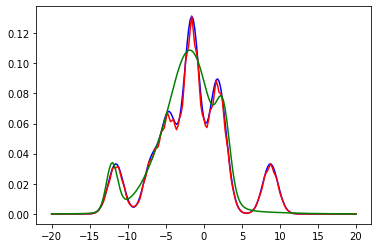

In [73]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot).detach().numpy()
yplot2 = logprobgp.predict(xplot,return_cov=False).detach().numpy()
yplot3 = distrib.logprob(xplot).detach().numpy().reshape(-1,1)
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
plt.plot(xplot,np.exp(yplot3),'g')


In [67]:
mixmeans

tensor([[  0.0000],
        [ -2.0015],
        [-11.1066],
        [  2.4547],
        [  1.2085],
        [ -6.9417],
        [ -5.1998],
        [ -5.1772],
        [ -5.1097],
        [  0.9014],
        [ -1.2424],
        [  0.3879],
        [  0.9383],
        [ -1.1825],
        [  1.1225],
        [  1.1218],
        [ -2.1024],
        [ -5.1252],
        [ -1.5324],
        [ -1.2997],
        [ -5.2482]])

In [180]:
distrib.logprob(xplot).detach().numpy().reshape(-1,1)

array([[-9.7850275],
       [-9.693792 ],
       [-9.602927 ],
       [-9.512285 ],
       [-9.421689 ],
       [-9.330922 ],
       [-9.23973  ],
       [-9.147815 ],
       [-9.054829 ],
       [-8.960385 ],
       [-8.864056 ],
       [-8.765381 ],
       [-8.663886 ],
       [-8.559093 ],
       [-8.450556 ],
       [-8.337875 ],
       [-8.22074  ],
       [-8.098945 ],
       [-7.9724154],
       [-7.8412333],
       [-7.7056265],
       [-7.565976 ],
       [-7.422797 ],
       [-7.276711 ],
       [-7.1284237],
       [-6.97869  ],
       [-6.828284 ],
       [-6.6779766],
       [-6.5285115],
       [-6.380593 ],
       [-6.2348695],
       [-6.091934 ],
       [-5.952317 ],
       [-5.816489 ],
       [-5.684864 ],
       [-5.557799 ],
       [-5.4356008],
       [-5.318532 ],
       [-5.2068095],
       [-5.1006155],
       [-5.0000935],
       [-4.9053545],
       [-4.8164806],
       [-4.7335215],
       [-4.6564984],
       [-4.5854015],
       [-4.5201855],
       [-4.46

In [55]:
alpha_relbo = 1e-1
maxiter_relbo = 100
alpha_boost = 1e-1
maxiter_boost = 100
maxiter = 20

mixmeans = torch.zeros(1,ndim)
mixvars = (20.0/3)**2*torch.ones(1,ndim)
mixweights = torch.ones(1)
for k in range(maxiter):
    mean0 = bvbq_torch.distributions.MixtureDiagonalNormalDistribution.sample_(1,mixmeans,mixvars,mixweights)[0,:]
    var0 = torch.distributions.HalfNormal(1.0).sample((ndim,))
    rawvar0 = torch.log(torch.exp(var0)-1)
    optimizer = torch.optim.Adam([mean0,rawvar0],alpha_relbo)
    mean0.requires_grad = True
    rawvar0.requires_grad = True
#     reg = torch.rand(1)
    for i in range(maxiter_relbo):
        optimizer.zero_grad()
        var0 = torch.log(torch.exp(rawvar0)+1)
        reg = torch.rand(1)
        relbo = bvbq_torch.bvbq_functions.mcbq_dmvn_relbo(logprobgp,mean0,var0,mixmeans,mixvars,mixweights,reg=reg)
        loss = -relbo
        loss.backward()
        optimizer.step()
    mean = mean0.detach()
    rawvar = rawvar0.detach()
    var = torch.log(torch.exp(rawvar)+1.0)
    weight = torch.tensor(1e-4)
    grad_term_logprob = bvbq_torch.bvbq_functions.logprob_terms_mixdmvn_delbodw(weight,
                                                                                logprobgp,
                                                                                mean,var,
                                                                                mixmeans,mixvars,
                                                                                mixweights)
    for j in range(maxiter_boost):
        grad_term_entropy = bvbq_torch.bvbq_functions.entropy_terms_mixdmvn_delbodw(weight,
                                                                                    mean,
                                                                                    var,
                                                                                    mixmeans,
                                                                                    mixvars,
                                                                                    mixweights,
                                                                                    nsamples=1000)
        grad = grad_term_logprob + grad_term_entropy
#         grad = bvbq_torch.bvbq_functions.mcbq_mixdmvn_delbodw(weight,
#                                                  logprobgp,
#                                                  mean,
#                                                  var,
#                                                  mixmeans,
#                                                  mixvars,
#                                                  mixweights,
#                                                  nsamples=1000)
        dweight = alpha_boost/(k+1)*grad
        weight += dweight
        weight = torch.clamp(weight,1e-4,1-1e-4)
    mixmeans = torch.vstack([mixmeans,mean])
    mixvars = torch.vstack([mixvars,var])
    mixweights = torch.hstack([(1-weight)*mixweights,weight])
    print(mean,var,weight)
# maxiter = kwargs.get("maxiter_nc",300)
# lr = kwargs.get("lr_nc",0.1)
# distrib_constant = kwargs.get("distrib_constant_nc",1.0)
# distrib_type = kwargs.get("distrib_type_nc","HN")
# verbose = kwargs.get("verbose",1)
# nsamples_nc = kwargs.get("n_samples_nc",100)
# if self.num_mixtures == 0:
#     raise NotImplementedError
# else:
#     mu0 = self._sample_from_current(1,flatten=True)
#     if distrib_type == "HN":
#         distrib = torch.distributions.HalfNormal
#     elif distrib_type == "HC":
#         distrib = torch.distributions.HalfCauchy
#     cov0 = distrib(torch.tensor([distrib_constant],device=self.device)).\
#                 sample((self.dim,)).flatten()
#     raw_cov0 = utils.invsoftplus(cov0)
#     theta0 = torch.cat([mu0,raw_cov0])
# theta0.requires_grad = True
# optimizer = torch.optim.Adam([theta0],lr=lr)
# for i in range(maxiter):
#     optimizer.zero_grad()
#     theta0.requires_grad = True
#     loss = self._evaluate_loss(theta0,nsamples=nsamples_nc,
#                               verbose=verbose)
#     if verbose >= 2:
#         print(theta0)
#         print(loss)
#     loss.backward()
#     optimizer.step()
# mu = theta0[:self.dim].detach()
# cov = (utils.softplus(theta0[self.dim:])).detach() #covariance
# if verbose >= 1:
#     print(loss)
# return mu,cov

tensor([-11.8285]) tensor([0.4976]) tensor(0.1327)
tensor([-2.0054]) tensor([3.5399]) tensor(0.7706)
tensor([2.5362]) tensor([0.4516]) tensor(0.1412)
tensor([-0.2610]) tensor([6.8757]) tensor(0.0216)
tensor([-8.7760]) tensor([5.0642]) tensor(0.0979)
tensor([-12.1265]) tensor([0.9025]) tensor(0.0301)
tensor([-6.1218]) tensor([1.1819]) tensor(0.0905)
tensor([0.9712]) tensor([2.6018]) tensor(0.1147)
tensor([-5.2415]) tensor([2.9516]) tensor(0.0396)
tensor([-2.8030]) tensor([6.5276]) tensor(0.0245)
tensor([-0.0194]) tensor([6.8075]) tensor(0.0111)
tensor([1.0070]) tensor([4.1454]) tensor(0.0036)
tensor([-0.2075]) tensor([4.8808]) tensor(0.0311)
tensor([-1.0863]) tensor([4.9748]) tensor(0.0300)
tensor([-1.1797]) tensor([6.4069]) tensor(0.0144)
tensor([-4.6402]) tensor([5.3485]) tensor(0.0029)
tensor([-2.2033]) tensor([8.2416]) tensor(0.0075)
tensor([-1.1506]) tensor([4.5256]) tensor(0.0148)
tensor([-11.6234]) tensor([1.3575]) tensor(0.0247)
tensor([-2.2240]) tensor([7.2275]) tensor(0.0185)


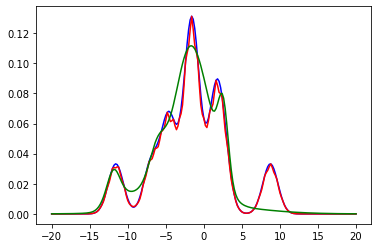

In [57]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot).detach().numpy()
yplot2 = logprobgp.predict(xplot,return_cov=False).detach().numpy()
yplot3 = distrib.logprob(xplot).detach().numpy().reshape(-1,1)
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
plt.plot(xplot,np.exp(yplot3),'g')
